# Neural Net Demo

- do not use this, it barely works. 
- it serves as an example of what happens when you feed a raw curve into a neural net. 
- it is not a good example of how to use a neural net.

## update

- this is being reworked to demonstrate an actual, working NN demo

## method

- One approach you could take is to first represent each curve in your cache as a set of ordered points in the Cartesian plane. You could then represent your input curve in the same way. You could then use a machine learning model, such as a neural network, to predict the ordered set of points that represents the curve in the cache that is most similar to the input curve.

- To train the model, you would need to define a loss function that measures the difference between the predicted curve and the input curve. This loss function could be based on the Euclidean distance between the corresponding points on the two curves, possibly with some weights applied to give more or less importance to certain points.

- For example, you could define the loss function as the sum of the squared Euclidean distances between each pair of corresponding points, divided by the number of points in the curve. This would give you an average distance between the two curves.

- You could also consider using a loss function that takes into account the partial nature of the curves, for example by weighting points that are closer to the start or end of the curve more heavily, since these points may be more indicative of the overall shape of the curve.

- Once you have defined your loss function and trained your model, you can use it to predict the curve in the cache that is most similar to the input curve by minimizing the loss function.


## Running a jupyter server for this notebook using System76's `tensorman`

In bash:

`tensorman run -p 8888:8888 --gpu --python3 --jupyter --root bash`

`pip3 install -r requirements.txt && jupyter notebook --ip=0.0.0.0 --no-browser --allow-root`

to do both together:

`tensorman run -p 8888:8888 --gpu --python3 --jupyter --root bash -c "pip3 install -r requirements.txt && jupyter notebook --ip=0.0.0.0 --no-browser --allow-root"`

In [1]:
from src.generation import generate_k_parameters
from src.zsoc import OCV_curve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import random

2023-01-21 23:13:30.382941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# import the dataset
df = pd.read_csv('./res/K_para.csv')
df = df.drop(columns=['Sample No.', 'Battery Manufacturer', 'Serial Number', 'Cell Number'])
data = df.to_numpy()

# truncate off the last column (R0)
batteries = data[:, :-1]
print(batteries.shape)

(34, 8)


## Need to import the curve cache

- this also graphs the lower 20% of the graphs, since this is where most of the differences are

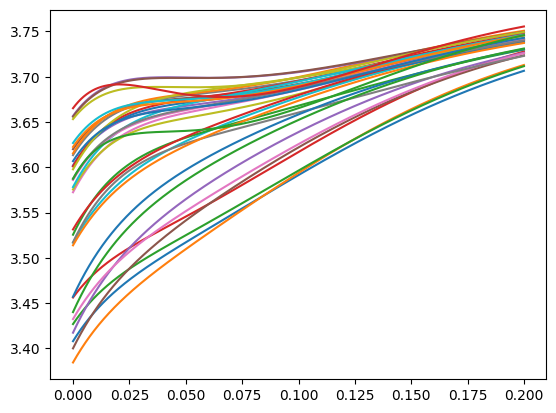

(34, 10000)


In [3]:
# generate ocv curves for each battery
# for this stage, we will just use OCV curves as input
curves = []
for battery in batteries:
    res = 10000
    b = OCV_curve(battery, resolution=res)
    plt.plot(b['zsoc'][0:int(10000*0.2)], b['Vo'][0:int(10000*0.2)])
    assert (isinstance(b['zsoc'], np.ndarray))
    curves.append(b['Vo'])
plt.show()

curves = np.array(curves)
print(curves.shape)


## Metrics and Algorithms

Referenced from [State of Charge Estimation of Lithium-Ion Battery for Electric Vehicles Using Machine Learning Algorithms](https://pdfs.semanticscholar.org/824a/26d71cf5bc45c7bcd9730d80c0aec5fb1f46.pdf).

### Algorithms

We will be evaluating a list of algorithms to determine which is the best for our use case. The algorithms we will be evaluating are:

1. SVM
2. Artificial Neural Network
3. Gaussian Process Regression
4. Linear Regression
5. Ensembled Bagging
6. Ensembled Boosting

## Performance Indices

1. MSE
2. RMSE
3. MAE
4. MAPE
5. R-Squared

**note**: I used WMSE as well, since I believe a weighted error is very important for this use case. However, given the nature of Neural Networks, it is probably not needed, but I would like to evaluate it anyways

**note**: this article is for direct estimation of SoC with a moving window of voltage, current and time vectors. We are interested in SoC as well, but only hard-coded. We are going to take a similar approach to estimate the OCV parameters, so we can estimate SoC offline. SoC AI is on the to-do, but only for online devices connected to the internet, for an AI-based estimation.

In [8]:
# To train the model, you would need to define a loss function that measures the difference between the predicted curve and the input curve. This loss function could be based on the Euclidean distance between the corresponding points on the two curves, possibly with some weights applied to give more or less importance to certain points.

# For example, you could define the loss function as the sum of the squared Euclidean distances between each pair of corresponding points, divided by the number of points in the curve. This would give you an average distance between the two curves.

# scaling can be done by taking the max and min difference for all curves in the cache at each point, and scaling them according to that distribution

# wmse generates a function that uses pre calculated weights to calculate the weighted mean squared error
def wmse():
    # weights = curves.transpose()
    # weights = np.array([abs(max(w) - min(w)) for w in weights])
    # use numpy.ptp instead
    weights = np.ptp(curves, axis=0)
    weights = weights / max(weights)
    weights = K.backend.constant(weights, dtype='float32')

    # define a loss function that calculates the weighted mean squared error
    def loss(y_true, y_pred):
        return K.backend.mean(K.backend.square(y_true - y_pred) * weights)
    return loss

# we still need more loss algorithms
# MSE, RMSE, MAE, MAPE, R-Squared

def mse():
    def loss(y_true, y_pred):
        return K.backend.mean(K.backend.square(y_true - y_pred))
    return loss

def rmse():
    def loss(y_true, y_pred):
        return K.backend.sqrt(K.backend.mean(K.backend.square(y_true - y_pred)))
    return loss

def mae():
    def loss(y_true, y_pred):
        return K.backend.mean(K.backend.abs(y_true - y_pred))
    return loss

def mape():
    def loss(y_true, y_pred):
        return K.backend.mean(K.backend.abs(y_true - y_pred) / K.backend.clip(K.backend.abs(y_true), K.backend.epsilon(), None))
    return loss

def r_squared():
    def loss(y_true, y_pred):
        SS_res =  K.backend.sum(K.backend.square(y_true - y_pred))
        SS_tot = K.backend.sum(K.backend.square(y_true - K.backend.mean(y_true)))
        return ( 1 - SS_res/(SS_tot + K.backend.epsilon()) )
    return loss

In [15]:
# each curve is going to be used as the input
# the output will be the corresponding k parameters

from keras import Input, Model, optimizers
# from keras.layers import GaussianProcess
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

models = []


# Support Vector Machine
SVM = Model([
    Input(shape=(1,)),
    Dense(8, activation='softmax')
])
SVM.compile(optimizer=optimizers.SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Artificial Neural Network
ANN = Sequential([
    Dense(100, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='linear')
]) 
ANN.compile(optimizer='adam', loss=wmse(), metrics=['accuracy'])
models.append(ANN)

# ANN 2 ------------------------------------------------


# # Create the voltage vector input
# voltage_vector = np.random.rand(100, 8)

# # Create the output labels
# labels = np.random.randint(0, 8, 100)

# # One-hot encode the labels
# labels = to_categorical(labels, num_classes=8)

# Create the model
ANN2 = Sequential()
ANN2.add(Dense(64, input_dim=8, activation='relu'))
ANN2.add(Dense(32, activation='relu'))
ANN2.add(Dense(8, activation='softmax'))

# Compile the model
ANN2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Fit the model to the data
# model.fit(voltage_vector, labels, epochs=10, batch_size=32)

# ------------------------------------------------------

# Gaussian Process Regression
# GPR = K.Model([
#     K.Input(shape=(1,)),
#     GaussianProcess(n_inducing_points=10, kernel=None),
#     Dense(1, activation='sigmoid'),
# ])
# GPR.compile(optimizer='adam', loss='binary_crossentropy')
# models.append(GPR)



ImportError: cannot import name 'GaussianProcess' from 'keras.layers' (/home/cole/.local/lib/python3.10/site-packages/keras/layers/__init__.py)

In [13]:
# need to make some kind of dataset that is simulated
# for now we will stick to ideal-case, full curves
# only do like ten epochs to avoid overfitting on such a small dataset

X = []
Y = []

eye = np.eye(len(curves))

for _ in range(100):
    i = np.random.randint(0, len(curves))
    X.append(curves[i])
    Y.append(eye[i])


In [14]:
# train the model
model.fit(X, Y, epochs=10)

NameError: name 'model' is not defined